In [ ]:
# Uncomment and run this cell if you're on Colab or Kaggle
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
# from install import *
# install_requirements()

In [1]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 97.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 kB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 65.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 56.7 MB/s eta 0:00:0000:0100:01

In [2]:
# hide
from utils import *
setup_chapter()

Using transformers v4.26.1
Using datasets v2.10.0


# Text Generation

<img alt="LM Meta Learning" width="800" caption="During pretraining, language models are exposed to sequences of tasks that can be adapted during inference (courtesy of Tom B. Brown)" src="images/chapter05_lm-meta-learning.png" id="lm-meta-learning"/>

<img alt="Meena" width="300" caption="Meena on the left telling a corny joke to a human on the right (courtesy of Daniel Adiwardana and Thang Luong)" src="images/chapter05_meena.png" id="meena"/>

## The Challenge with Generating Coherent Text

<img alt="Text generation" width="700" caption="Generating text from an input sequence by adding a new word to the input at each step" src="images/chapter05_text-generation.png" id="text-generation"/> 

## Greedy Search Decoding

In [3]:
# hide_output
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [4]:
input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model(input_ids=input_ids)
next_token_logits = output.logits[0, -1, :]
next_token_probs = torch.softmax(next_token_logits, dim=-1)
sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)

In [5]:
# hide_output
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)
        
pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (8.53%),only (4.96%),best (4.65%),Transformers (4.37%),ultimate (2.16%)
1,Transformers are the most,popular (16.78%),powerful (5.37%),common (4.96%),famous (3.72%),successful (3.20%)
2,Transformers are the most popular,toy (10.63%),toys (7.23%),Transformers (6.60%),of (5.46%),and (3.76%)
3,Transformers are the most popular toy,line (34.38%),in (18.20%),of (11.71%),brand (6.10%),line (2.69%)
4,Transformers are the most popular toy line,in (46.28%),of (15.09%),", (4.94%)",on (4.40%),ever (2.72%)
5,Transformers are the most popular toy line in,the (65.99%),history (12.42%),America (6.91%),Japan (2.44%),North (1.40%)
6,Transformers are the most popular toy line in the,world (69.26%),United (4.55%),history (4.29%),US (4.23%),U (2.30%)
7,Transformers are the most popular toy line in ...,", (39.73%)",. (30.64%),and (9.87%),with (2.32%),today (1.74%)


In [6]:
print(input_ids)
print(output[0])

tensor([[41762,   364,   389,   262,   749,  2968, 13373,  1627,   287,   262,
           995,    11]], device='cuda:0')
tensor([[[ 2.7388,  4.8211,  1.7156,  ..., -6.9956, -4.9382, -0.3056],
         [ 4.6024,  7.0256,  2.0684,  ..., -8.2232, -4.8386,  2.6589],
         [ 1.9228,  0.9972, -3.3385,  ..., -3.4645, -3.6465, -0.4307],
         ...,
         [-0.2814, -0.0597, -4.0544,  ..., -6.9407, -7.8547, -1.5933],
         [ 0.1605,  0.2670, -2.1840,  ..., -7.7966, -5.2849,  0.2788],
         [ 8.1076,  4.7803,  1.1597,  ..., -9.2347, -5.6519,  3.2676]]],
       device='cuda:0')


In [7]:
output[0].shape

torch.Size([1, 11, 50257])

In [8]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(f'No. steps: {n_steps}')
print(f'Input sequence:  {tokenizer.decode(input_ids.squeeze())}')
print(f'Output sequence: {tokenizer.decode(output.squeeze())}')

No. steps: 8
Input sequence:  Transformers are the
Output sequence: Transformers are the most popular toy line in the world,


In [9]:
max_length = 128
input_txt = """
In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""

input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)
print(tokenizer.decode(output_greedy.squeeze()))


In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, Davis, and the University of
Colorado, Boulder, were conducting a study on the Andean cloud forest, which is
home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to
communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were


## Beam Search Decoding

<img alt="Beam search" width="700" caption="Beam search with two beams—the most probable sequences at each timestep are highlighted in blue" src="images/chapter05_beam-search.png" id="beam-search"/> 

In [10]:
0.5 ** 1024

5.562684646268003e-309

In [11]:
import numpy as np

sum([np.log(0.5)] * 1024)

-709.7827128933695

In [12]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [13]:
def sequence_logprob(model, labels, input_len=0):
    with torch.inference_mode():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], # keep everthing except the nex token prediction to allign with input
            labels[:, 1:] # keep everything except the firt token to allign with output
        )
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

In [14]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")


In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, Davis, and the University of
Colorado, Boulder, were conducting a study on the Andean cloud forest, which is
home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to
communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were

log-prob: -87.21


In [15]:
output_beam = model.generate(
    input_ids,
    max_length=max_length,
    num_beams=5,
    do_sample=False
)

logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")


In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery of the unicorns was made by a team of scientists from the
University of California, Santa Cruz, and the National Geographic Society.


The scientists were conducting a study of the Andes Mountains when they
discovered a herd of unicorns living in a remote, previously unexplored valley,
in the Andes Mountains. Even more surprising to the researchers was the fact
that the unicorns spoke perfect

log-prob: -55.39


In [16]:
output_beam = model.generate(
    input_ids,
    max_length=max_length,
    num_beams=5,
    do_sample=False,
    no_repeat_ngram_size=2
)

logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")


In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of scientists from the University of
California, Santa Cruz, and the National Geographic Society.

According to a press release, the scientists were conducting a survey of the
area when they came across the herd. They were surprised to find that they were
able to converse with the animals in English, even though they had never seen a
unicorn before. The scientists believe that

log-prob: -90.33


## Sampling Methods

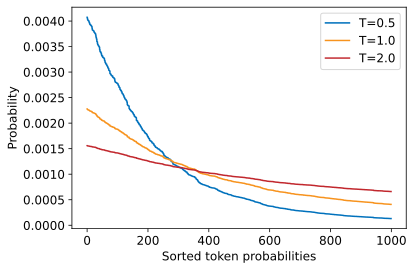

In [17]:
#hide_input

#id temperature
#alt Token probabilities as a function of temperature
#caption Distribution of randomly generated token probabilities for three selected temperatures
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

In [18]:
# hide
torch.manual_seed(42);

In [19]:
output_temp = model.generate(
    input_ids,
    max_length=max_length,
    do_sample=True,
    temperature=2.0,
    top_k=0
)

print(tokenizer.decode(output_temp[0]))


In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


While the station aren protagonist receive Peng Fan
nostalgiatestymologyromettaorial portrayed laugh atest irrational tale
accomplish Continent seaf Auct Turner Dor wondered for Pumpkin mere That
brilliant stall class inequariansiamond disse * Photographer awards high whilst
forearm secured conference be zo coachinginventoryatelleton press Vatican
credentials Wrestling chargesThingsctureddong Ty physicianness Kimville66 graz
Oz at aff da temporou MD6 Canada


In [20]:
# hide
torch.manual_seed(42);

In [21]:
output_temp = model.generate(
    input_ids,
    max_length=max_length,
    do_sample=True,
    temperature=0.5,
    top_k=0
)

print(tokenizer.decode(output_temp[0]))


In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists were able to receive the unicorn's unique communication through a
satellite communication device, which transmitted the unicorn's sounds to the
researchers' satellite. The researchers were able to receive the unicorn's
unique communication through a satellite communication device, which transmitted
the unicorn's sounds to the researchers' satellite.


The scientists were able to communicate with the unicorn and record their unique
calls, which they could then analyze


## Top-k and Nucleus Sampling

In [22]:
# hide
torch.manual_seed(42);

In [23]:
# hide
input_txt = """
In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [24]:
# hide
import torch.nn.functional as F

with torch.inference_mode():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

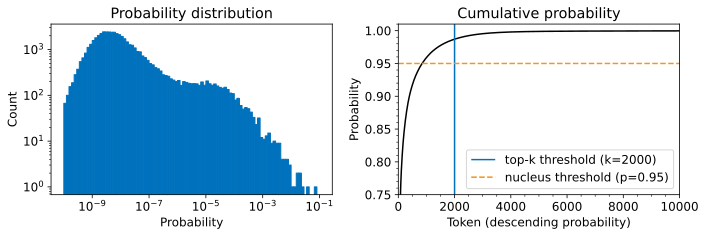

In [25]:
# hide_input

#id distribution
#alt Probability distribution of next token prediction.
#caption Probability distribution of next token prediction (left) and cumulative distribution of descending token probabilities

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

In [26]:
# hide
torch.manual_seed(42);

In [27]:
output_topk = model.generate(
    input_ids,
    max_length=max_length,
    do_sample=True,
    top_k=50
)

print(tokenizer.decode(output_topk[0]))


In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The wild unicorns roam the Andes Mountains in the region of Cajamarca, on the
border with Argentina (Picture: Alamy/Ecole Nationale Supérieure d'Histoire
Naturelle)

The researchers came across about 50 of the animals in the valley. They had
lived in isolation for decades and were found at a location only accessible by
four-


In [28]:
# hide
torch.manual_seed(42);

In [29]:
output_topp = model.generate(
    input_ids,
    max_length=max_length,
    do_sample=True,
    top_p=0.90
)

print(tokenizer.decode(output_topp[0]))


In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists studied the DNA of the animals and came to the conclusion that
the herd are descendants of a prehistoric herd that lived in Argentina about
50,000 years ago.


According to the scientific analysis, the first humans who migrated to South
America migrated into the Andes Mountains from South Africa and Australia, after
the last ice age had ended.


Since then, the Andes Mountains have remained


## Which Decoding Method Is Best?

## Conclusion